# Sampling with Space Partitioning

## Tutorial Notebook 

    Structure: 
    
    1. BAT model definition: Gaussian mixture
    2. Single-click run: Default settings  
    3. Detailed sampling summary
       -- @elapsed/@CPUelapsed time 
       -- Posterior integrals
       -- Plotting
    4. Fine-grained control: Samplers, integrators, partitioner 
       -- HMC/Sobol
    5. Kolmogorov–Smirnov tests
    
    --- 
    

In [1]:
# using Distributed 
# addprocs(3)

In [2]:
using IntervalSets
using Distributions
using Random, LinearAlgebra, Statistics, Distributions, StatsBase, ArraysOfArrays
using JLD2
using ValueShapes
using TypedTables
using Measurements
using TypedTables
using HypothesisTests

In [3]:
# using PyPlot
using Plots
pyplot()

Plots.PyPlotBackend()

In [4]:
using Revise
using BAT

┌ Info: Precompiling BAT [c0cd4b16-88b7-57fa-983b-ab80aecada7e]
└ @ Base loading.jl:1260


## 1. BAT model definition: Gaussian mixture

Let us use a mixture of 4 normal distribution with random  covariance matrices as a model: 

In [5]:
σ_1 = [3.426818298733095 12.378238116671048 -9.632531611142454; 3.426818298733095 4.916266580684483 -5.029942800849483; 3.426818298733095 -6.737309268887753 5.4343957706004415; 3.426818298733095 -3.9729587574454333 3.379361860370276]
σ_2 = [12.378238116671048 69.83909693165143 -43.478993858310886; 4.916266580684482 69.83909693165143 -64.18784570966332; -6.737309268887753 69.83909693165143 32.734776615550174; -3.972958757445433 69.83909693165143 53.74871853095418]
σ_3 = [-9.632531611142456 -43.478993858310886 60.0626256206892; -5.029942800849484 -64.18784570966332 60.0626256206892; 5.4343957706004415 32.734776615550174 60.0626256206892; 3.3793618603702757 53.74871853095418 60.0626256206892]
σ = cat(σ_1,σ_2,σ_3, dims=3)

μ = [8.959570984309234 -9.021529871694005 -5.007789383392622; -1.446445514344754 -7.8327010768703875 -3.2653263028963986; -6.40954093270941 0.25815094665222027 5.830143596540282; 5.076504517881521 -0.8952973253675331 9.16356325348496]

mixture_model = MixtureModel(MvNormal[MvNormal(μ[i,:], Matrix(Hermitian(σ[i,:,:])) ) for i in 1:4]);


In [6]:
prior = NamedTupleDist(a = [Uniform(-50,50), Uniform(-50,50), Uniform(-50,50)])

likelihood = let model = mixture_model
    params -> begin
        return LogDVal(logpdf(model, params.a))
    end
end

posterior = PosteriorDensity(likelihood, prior);
log_volume = BAT.log_volume(BAT.spatialvolume(posterior.parbounds))

13.815510557964275

## 2. Single-click run: Default settings 

Default parameters of the `PartitionedSampling()` algorithm: 

1) Exploration samples: `MetropolisHastings()` sampler (20 chains * 10^2 samples)

2) Sampling: `MetropolisHastings()` sampler

3) Space partitioning: `KDTreePartitioning()`

4) Reweighting: `AHMIntegration()`


In [7]:
n_chains = 5 # chains per subspace 
n_samples = 10^4 # samples per subspace 
n_subspaces = 10;

To generate samples with default settings

In [8]:
algorithm_1 = PartitionedSampling()

output_sp = bat_sample(posterior, (n_samples, n_chains, n_subspaces), algorithm_1)

samples_1 = output_sp.result;

┌ Info: Generating Exploration Samples
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/partitioned_sampling/partition_sample.jl:71
┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 30 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 30 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 30 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 30 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 30 chains, 2 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info:

In [9]:
algorithm_2 = MetropolisHastings()

output_mcmc = bat_sample(posterior, (n_samples*n_subspaces, n_chains), algorithm_2)

samples_2 = output_mcmc.result;

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 5 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 5 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 5 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 5 chains, 0 tuned, 5 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 5 chains, 0 tuned, 5 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 3 finished, 5 chains, 0 tuned, 5 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ I

Standard BAT statistics on the posterior DensitySampleVector:

In [10]:
println("Mode: $(mode(samples_1))")
println("Mode: $(mode(samples_2))")

println("Mean: $(mean(samples_1))")
println("Mean: $(mean(samples_2))")

Mode: ShapedAsNT((a = [-1.481547316331852, -7.810590659816519, -3.286907016380023],))
Mode: ShapedAsNT((a = [-1.4318469768918218, -7.659273619281654, -3.399261699217707],))
Mean: ShapedAsNT((a = [1.549800176459366, -4.350157446080147, 1.732400933367472],))
Mean: ShapedAsNT((a = [1.4933936547786433, -4.281085245188197, 1.8160085870911884],))


Standard BAT plotting recipes: 

┌ Warning: var will default to corrected=true in the future. Use corrected=false for previous behaviour.
│   caller = ip:0x0
└ @ Core :-1


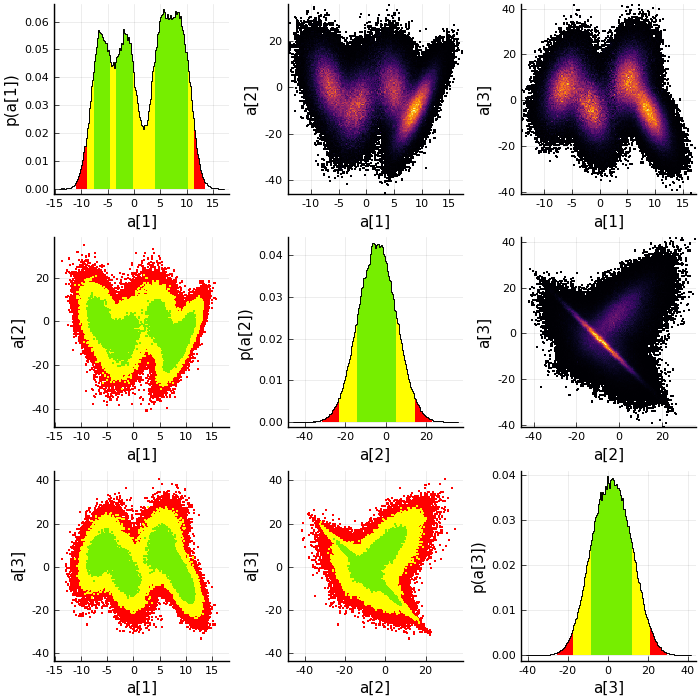

In [11]:
plot(samples_1, size=(700,700), upper=Dict("mean"=>false, "globalmode"=>false, "localmode"=>false))

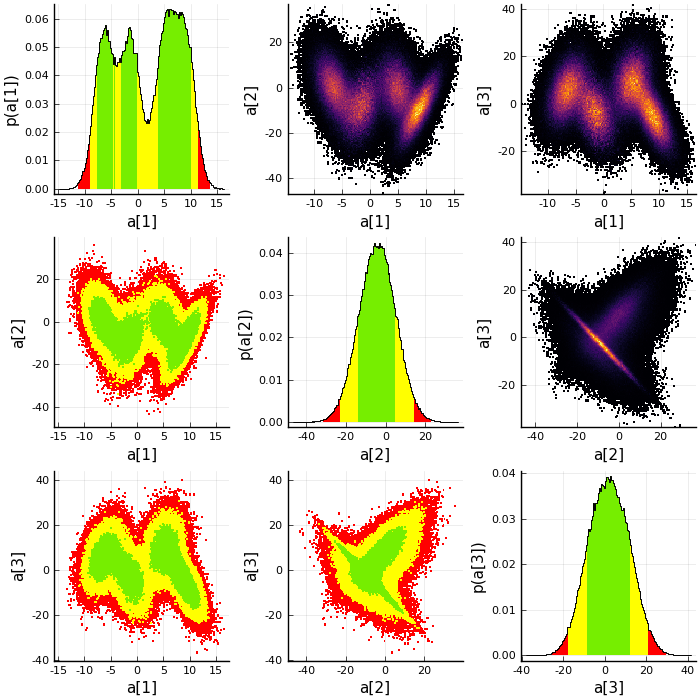

In [12]:
plot(samples_2, size=(700,700), upper=Dict("mean"=>false, "globalmode"=>false, "localmode"=>false))

## 3. Detailed sampling summary

Run information:

In [13]:
columnnames(output_sp.info)

(:density_integral, :sampling_cpu_time, :integration_cpu_time, :sampling_wc, :integration_wc, :worker_id, :n_threads, :samples_ind)

In [14]:
output_sp.info[1:10]

Table with 8 columns and 10 rows:
      density_integral  sampling_cpu_time  integration_cpu_time  ⋯
    ┌─────────────────────────────────────────────────────────────
 1  │ 1.777e-7±2.5e-9   9.31859            3.275                 ⋯
 2  │ 1.265e-7±1.5e-9   7.38271            0.624275              ⋯
 3  │ 7.699e-8±8.1e-10  7.78542            0.590852              ⋯
 4  │ 1.439e-7±1.7e-9   7.00332            0.717743              ⋯
 5  │ 6.492e-8±4.4e-10  5.03398            0.651411              ⋯
 6  │ 8.412e-8±6.5e-10  4.42525            0.951202              ⋯
 7  │ 5.589e-8±3.9e-10  5.09993            0.690474              ⋯
 8  │ 6.093e-8±5.9e-10  5.28639            0.711639              ⋯
 9  │ 9.63e-8±1.3e-9    5.84309            0.64934               ⋯
 10 │ 1.124e-7±1.2e-9   4.70478            0.694499              ⋯

In [15]:
posterior_integral = sum(output_sp.info.density_integral)

9.997e-7 ± 4.0e-9

In [ ]:
log(posterior_integral)

In [16]:
total_cpu_time = sum(output_sp.info.sampling_cpu_time) + sum(output_sp.info.integration_cpu_time)

71.439888

In [17]:
total_wc_time = (output_sp.info.sampling_wc[end][end] - output_sp.info.sampling_wc[1][1])*1e-9

25.515

Partition tree: 

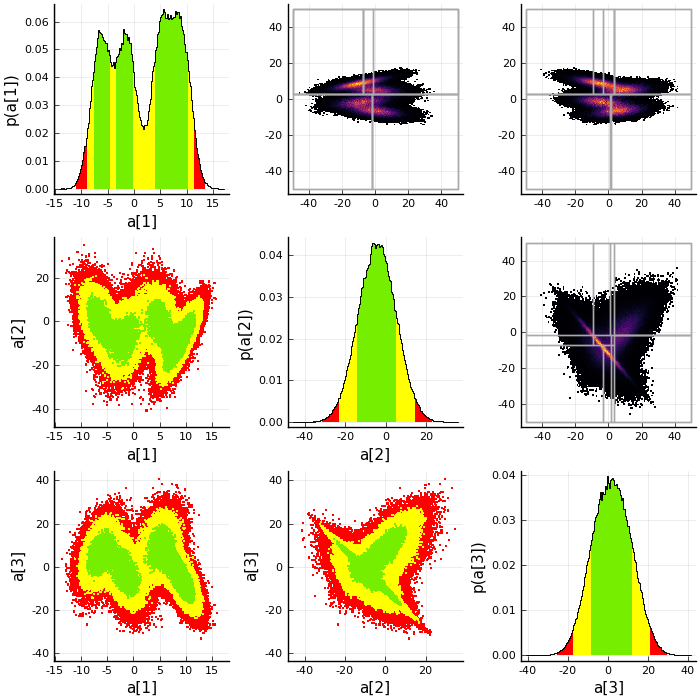

In [18]:
plot(samples_1, size=(700,700), upper=Dict("partition_tree"=>output_sp.part_tree, "mean"=>false, "globalmode"=>false, "localmode"=>false))

Exploration samples: 

In [19]:
n_explorstion = length(output_sp.exp_samples)

3000

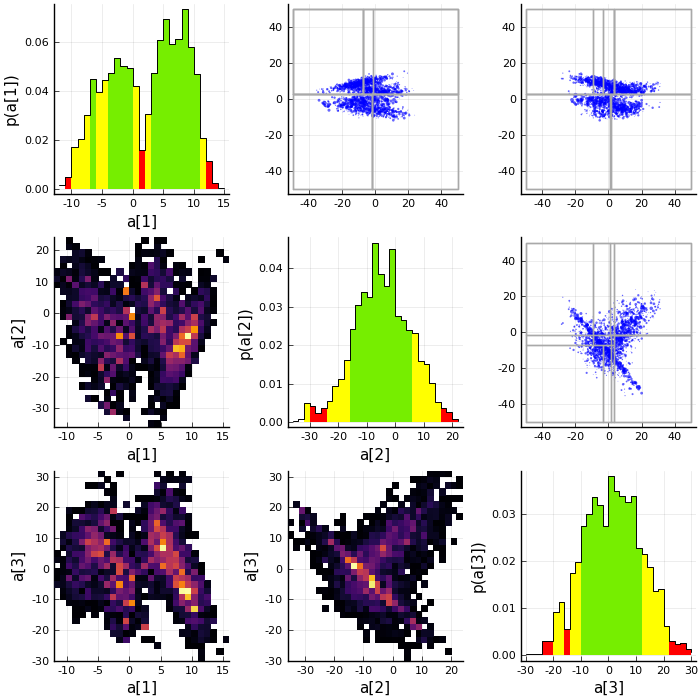

In [20]:
plot(output_sp.exp_samples, size=(700,700), 
    upper = Dict("seriestype"=>:scatter, "colors"=>:red, "partition_tree"=>output_sp.part_tree,), 
    lower = Dict("seriestype"=>:hist, "bins"=>30),
    diagonal = Dict("bins"=>30),)

## 4. Fine-grained control: Samplers, integrators, partitioner 

Subspace sampler can be any `BAT.AbstractSamplingAlgorithm` algorithm: 

In [21]:
sampler = MetropolisHastings() # AHMC()

burnin_1 = MCMCBurninStrategy(
        max_nsamples_per_cycle = 400,
        max_nsteps_per_cycle = 400,
        max_time_per_cycle = 25,
        max_ncycles = 20
    )

sampling_kwargs = (burnin = burnin_1,);

The same with exploration sampler

In [22]:
# Sobol Sampler: 
# exploration_sampler = BAT.SobolSampler()
# exploration_kwargs = NamedTuple()
# n_exploration = (10^2, 40);

# MetropolisHastings: 
exploration_sampler = MetropolisHastings()
burnin_2 = MCMCBurninStrategy(
        max_nsamples_per_cycle = 400,
        max_nsteps_per_cycle = 400,
        max_time_per_cycle = 25,
        max_ncycles = 5
    )
exploration_kwargs = (burnin = burnin_1,)
n_exploration = (10^2, 40);

Space partitioning can be done using `BAT.KDTreePartitioning` algorithm

In [23]:
partitioner = KDTreePartitioning(
        partition_dims = [1,2,], # dimension indices that are considered for partition
        extend_bounds=false # "false" is appropriate for debugging, very fast tuning /convergence 
    );

To integrate subspaces, any `BAT.IntegrationAlgorithm` can be used: 

In [24]:
integrator = AHMIntegration(  
        whitening= CholeskyPartialWhitening(),
        autocorlen= GeyerAutocorLen(),
        volumetype = :HyperRectangle,
        max_startingIDs = 10000,
        max_startingIDs_fraction = 2.5,
        rect_increase = 0.1,
        warning_minstartingids = 16,
        dotrimming = true,
        uncertainty= [:cov]
    );

Finally, `PartitionedSampling` can be defined using settings: 

In [25]:
algorithm = PartitionedSampling(
        sampler = sampler,
        exploration_sampler = exploration_sampler,
        partitioner = partitioner,
        integrator = integrator,
        exploration_kwargs = exploration_kwargs,
        sampling_kwargs = sampling_kwargs,
        n_exploration = n_exploration
    );

In [26]:
output_sp_ms = bat_sample(posterior, (n_samples, n_chains, 40), algorithm);

samples_3 = output_sp_ms.result;

┌ Info: Generating Exploration Samples
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/partitioned_sampling/partition_sample.jl:71
┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 40 viable MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:193
┌ Info: Selected 40 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:304
┌ Info: Begin tuning of 40 MCMC chain(s).
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:65
┌ Info: MCMC Tuning cycle 1 finished, 40 chains, 0 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info: MCMC Tuning cycle 2 finished, 40 chains, 2 tuned, 0 converged.
└ @ BAT /Users/vhafych/MPP-Server/gitrepos/BAT.jl/src/samplers/mcmc/mcmc_tuner.jl:98
┌ Info:

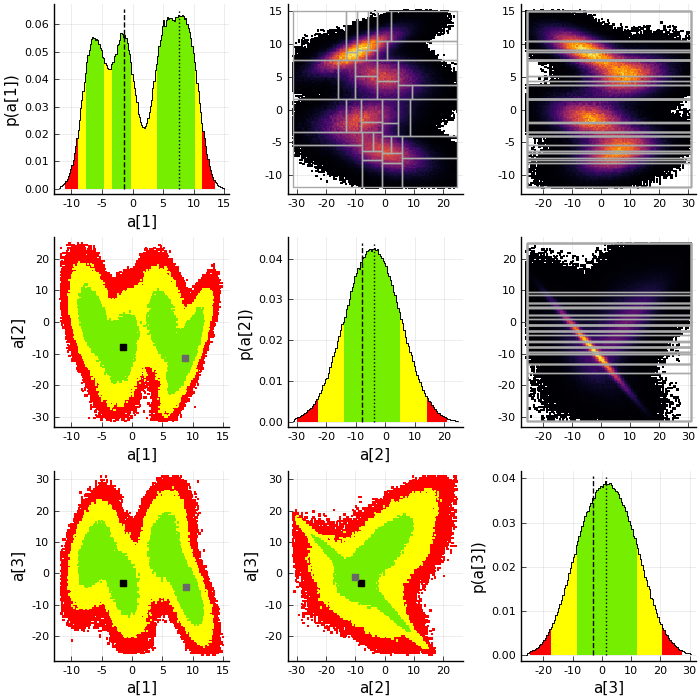

In [27]:
plot(samples_3, vsel=[1,2,3], size=(700,700), globalmode=true, localmode=true, 
    upper=Dict("partition_tree"=>output_sp_ms.part_tree, 
        "mean"=>false, "globalmode"=>false, "localmode"=>false))

In [28]:
posterior_integral = sum(output_sp_ms.info.density_integral)

9.922e-7 ± 1.4e-9

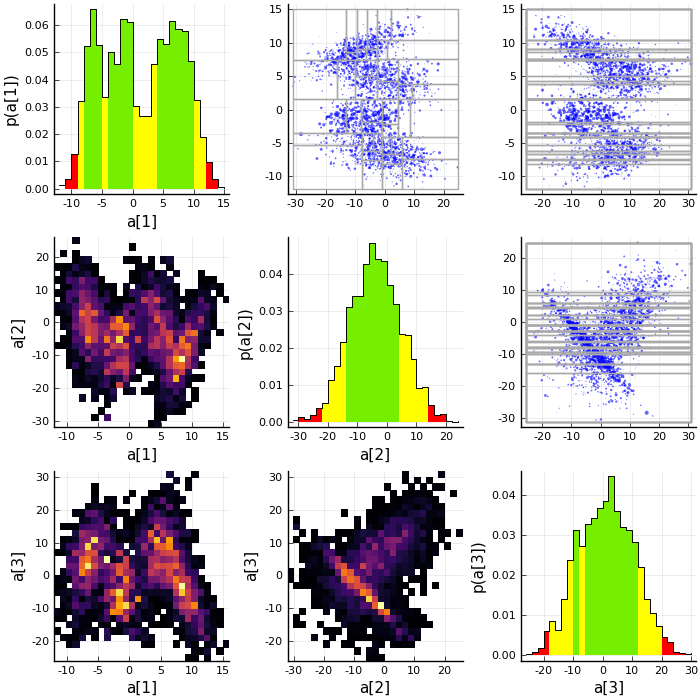

In [29]:
plot(output_sp_ms.exp_samples, size=(700,700), 
    upper = Dict("seriestype"=>:scatter, "partition_tree"=>output_sp_ms.part_tree,), 
    lower = Dict("seriestype"=>:hist, "bins"=>30),
    diagonal = Dict("bins"=>30),)

## 5. Kolmogorov–Smirnov tests

In [30]:
@show bat_eff_sample_size(samples_1).result
@show length(samples_1)

ArgumentError: ArgumentError: smpls.v isa AbstractVector{<:AbstractVector{<:Real}} must hold. Got
smpls.v => ShapedAsNTArray with 1 column and 500000 rows:
      a
    ┌───────────────────────────────
 1  │ [-7.95535, -1.74117, -10.6876]
 2  │ [-8.16925, -1.84369, -12.9558]
 3  │ [-7.429, -3.72654, -13.0563]
 4  │ [-7.66688, -7.25149, -12.5359]
 5  │ [-9.45792, -8.60856, -10.0273]
 6  │ [-9.09648, -6.71719, -12.1628]
 7  │ [-8.48741, -8.10004, -10.4527]
 8  │ [-7.53737, -6.75118, -9.60882]
 9  │ [-9.99027, -4.60374, -6.6485]
 10 │ [-9.00439, -6.50075, -6.70757]
 11 │ [-5.098, -10.2056, -6.4475]
 12 │ [-5.34942, -10.1986, -5.76956]
 13 │ [-5.05565, -10.3985, -2.45874]
 14 │ [-6.40367, -11.1234, -5.68595]
 15 │ [-5.57818, -8.12157, -5.27842]
 16 │ [-5.36, -9.49595, -7.32371]
 17 │ [-9.10675, -7.41944, -8.11973]
 18 │ [-8.04489, -9.26867, -3.26419]
 19 │ [-8.83137, -8.17019, -3.04645]
 20 │ [-7.23208, -9.81729, -3.92213]
 21 │ [-8.90866, -5.47854, -3.62151]
 22 │ [-8.72206, -8.13943, -3.56752]
 23 │ [-7.29146, -11.5666, -1.7085]
 ⋮  │               ⋮
AbstractVector{<:AbstractVector{<:Real}} => AbstractArray{#s41,1} where #s41<:(AbstractArray{#s40,1} where #s40<:Real)

In [31]:
@show bat_eff_sample_size(samples_2).result
@show length(samples_2)

ArgumentError: ArgumentError: smpls.v isa AbstractVector{<:AbstractVector{<:Real}} must hold. Got
smpls.v => ShapedAsNTArray with 1 column and 500000 rows:
      a
    ┌─────────────────────────────────
 1  │ [-9.16278, -1.37374, 0.719902]
 2  │ [-9.82461, 3.626, -0.373883]
 3  │ [-9.22722, 6.08219, 5.10034]
 4  │ [-6.80659, -2.03061, 1.9319]
 5  │ [-7.38482, 0.975818, 2.45531]
 6  │ [-7.01919, -1.91053, 0.716459]
 7  │ [-6.32669, -1.90027, -2.08046]
 8  │ [-6.337, -1.68779, 2.89117]
 9  │ [-1.88216, -3.25135, -10.3375]
 10 │ [-1.34898, -2.73953, -5.69935]
 11 │ [-1.32496, -6.0038, -5.63047]
 12 │ [0.133257, -7.08473, -5.24014]
 13 │ [-0.0338698, -6.25747, -5.87239]
 14 │ [-1.49112, -9.36554, -1.6553]
 15 │ [-3.18614, -11.5342, -0.224405]
 16 │ [-1.70011, -12.6768, -0.422392]
 17 │ [-6.07916, -12.1508, -1.66838]
 18 │ [-7.05931, -8.41354, 1.42352]
 19 │ [2.11453, 9.85875, 11.2525]
 20 │ [3.64711, 8.73547, 16.03]
 21 │ [4.21227, 7.3642, 14.7681]
 22 │ [2.76669, 5.31581, 13.3976]
 23 │ [1.16571, 12.6828, 15.9428]
 ⋮  │                ⋮
AbstractVector{<:AbstractVector{<:Real}} => AbstractArray{#s41,1} where #s41<:(AbstractArray{#s40,1} where #s40<:Real)

In [32]:
bat_compare(samples_1, samples_2)

3-element Array{Float64,1}:
 1.2535862883733032e-5
 3.1249651628849444e-11
 2.468989259040304e-6